In [ ]:
#this line is used to connext the code to the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pyunpack
!pip install patool

In [ ]:

#the data in the cloud was compressed, so we used this line of code to ex5ract the data to desired folder
from pyunpack import Archive
Archive('/content/drive/My Drive/GaitLocomotionDisorder/Normal.rar/Dataset_Copy.rar').extractall('/content/drive/My Drive/GaitLocomotionDisorder/NormalDataset')

# 1- Importing Libraries

In [ ]:

#importing the libraries used in the code
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.mixture import GaussianMixture as GMM

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 2- Setting Variables

In [ ]:

image_w = 220
image_h = 140
batch_size = 32
epochs = 30

#Defining the Video Dataset Directory

In [ ]:

#Defining the folder containing the dataset of one of the classes
Abnormalbefore = glob.glob("/content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Dataset Before Conversion to image files/*")
print("Abnormal before Conversion lens is {}".format(len(Abnormalbefore)))
print(Abnormalbefore[0])

Abnormal before Conversion lens is 4
/content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Dataset Before Conversion to image files/y2mate.com - Brain Injury Gait Case Study 23_1080pFHR (online-video-cutter.com).mp4


Converting the Dataset from Videos to images

In [ ]:
import cv2
import os
# Define the interval to save frames
interval = 400  # Adjust as needed

z = 0
for i in range(1, len(Abnormalbefore)):

    # Read the video from specified path
    cam = cv2.VideoCapture(Abnormalbefore[i])

    print("Finished With a Video")

    try:
        # creating a folder named data
        if not os.path.exists('data'):
            os.makedirs('data')
    except OSError:
        print('Error: Creating directory of data')

    # frame
    currentframe = 0

    while(True):

        # reading from frame
        ret, frame = cam.read()

        if ret:
            # Check if current frame is a multiple of interval
            if currentframe % interval == 0:
                # if video is still left continue creating images
                name = '/content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.' + str(z + 1) + ' of video' + '.jpg'
                print('Creating...' + name)
                frame = cv2.resize(frame, (220,140))
                img2 = frame.reshape((-1, 3))
                z += 1

                #sending the images to the gmm model to remove the unwanted data and saving the images to the drive
                gmm_model = GMM(n_components=2, covariance_type='tied').fit(img2)
                gmm_labels = gmm_model.predict(img2)

                # This changes the output values of the vector from (0 or 1) to (0 or 255).
                # 0 is black and 255 is white, so image can be distinguished
                for i in range(gmm_labels.shape[0]):
                    if gmm_labels[i] == 0:
                        gmm_labels[i] = 255
                    elif gmm_labels[i] == 255:
                        gmm_labels[i] = 0

                segmented = gmm_labels.reshape(frame.shape[0], frame.shape[1])

                # writing the extracted images
                cv2.imwrite(name, segmented)

            # increasing counter so that it will show how many frames are created
            currentframe += 1
        else:
            break

    # Release all space and windows once done
    cam.release()
    cv2.destroyAllWindows()

Finished With a Video
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.1 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.2 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.3 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.4 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.5 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 image N.6 of video.jpg
Creating.../content/drive/MyDrive/GaitLocomotionDisorder/Abnormal Converted Dataset/Segmented with 2 GMMs comp3 of Vid2 

# 3- Input the dataset

In [ ]:

#defining the folders containing the dataset and the images.
data_dir = '/content/drive/MyDrive/GaitLocomotionDisorder'
base_dir="/content/drive/MyDrive/GaitLocomotionDisorder"

import pathlib
data_dir = pathlib.Path(data_dir)
list(data_dir.glob('*/*.png'))

N1 = glob.glob(base_dir + '/NormalDataset/Dataset - Copy/Normal Gait/*')
N2 = glob.glob(base_dir + '/NormalDataset/Dataset - Copy/Normal Gait 2/fq00/*')
N3 = glob.glob(base_dir + '/NormalDataset/Dataset - Copy/Normal Gait 2/fq01/*')
N4 = glob.glob(base_dir + '/NormalDataset/Dataset - Copy/Normal Gait 2/fs00/*')
N5 = glob.glob(base_dir + '/NormalDataset/Dataset - Copy/Normal Gait 2/fs01/*')
Normal = N1+N2+N3+N4+N5

Abnormal  = glob.glob(base_dir + '/Abnormal Converted Dataset/*')

image_count = len(list(data_dir.glob('*/*.jpg')))
objects = {
'Normal Gait' : list(Normal),
'Abnormal Gait' : list(Abnormal)
}

objects_labels = {
    'Normal Gait' : 0,
   'Abnormal Gait' : 1,
    }
#printing the number of each class's images
print("Number of Normal Images : " + str(len(objects['Normal Gait'])))
print("Number of Abnormal Images : " + str(len(objects['Abnormal Gait'])))

Number of Normal Images : 8552
Number of Abnormal Images : 51


# 4- Adding Labels to the Dataset

In [ ]:

#transforming the images into number and assigning a label to each image
X, y = [], []
w = 1
for name, images in objects.items():
    print("Printing...")
    for image in images:

        img = cv2.imread(str(image))


        try:
            resized = cv2.resize(img, (220,140))
            print(w)
            w = w + 1
            X.append(resized)
            y.append(objects_labels[name])
        except:
            print('skipped')
            break

X = np.array(X)
y = np.array(y)
print("Finished")
print(Normal[0])
print(Abnormal[0])

Streaming output truncated to the last 5000 lines.
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797

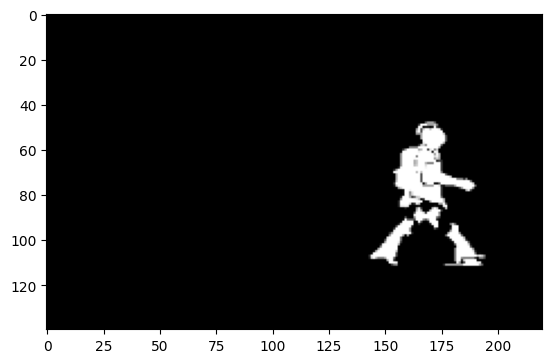

In [ ]:
plt.figure()
plt.imshow(X[0])

# 5- Splitting the Data

In [ ]:

#splitting the data to define the testing sample and the training one
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(len(X_train), len(X_test),len(y_train), len(y_test))

6882 1721 6882 1721


# 9- Building The Model

In [ ]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same',
           activation ='relu', input_shape = (image_h, image_w, 3)),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss',
                   patience=8,
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
#                                  patience = 4,
#                                  verbose=1,
#                                  factor=0.5,
#                                  min_lr=0.00005)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 140, 220, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 70, 110, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 70, 110, 64)       18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 35, 55, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 35, 55, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 27, 128)      

#10- Training the Model

In [ ]:
history = model.fit(X_train, y_train, epochs = 30)

Epoch 1/30
216/216 [==============================] - 699s 3s/step - loss: 5.2035 - accuracy: 0.9977
Epoch 2/30
216/216 [==============================] - 705s 3s/step - loss: 1.9770e-04 - accuracy: 0.9999
Epoch 3/30
216/216 [==============================] - 697s 3s/step - loss: 1.1274e-06 - accuracy: 1.0000
Epoch 4/30
216/216 [==============================] - 694s 3s/step - loss: 1.0058e-04 - accuracy: 1.0000
Epoch 5/30
216/216 [==============================] - 699s 3s/step - loss: 1.2846e-07 - accuracy: 1.0000
Epoch 6/30
 96/216 [============>.................] - ETA: 6:32 - loss: 1.7329e-07 - accuracy: 1.0000

In [ ]:
model.evaluate(X_test, y_test)

#11- Plotting the accuracy and the Lost Function

In [ ]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

#12- Plotting the Confusion Matrix of the Model

In [ ]:
predictions = model.predict_classes(X_test)

cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(conf_mat = cm,
                      figsize=(8,7),
                      show_normed=True)

#13- Calculating the Accuracy of the model


In [ ]:
test_accuracy = (cm[0, 0] + cm[1, 1])/ len(X_test)
print("Test Accuracy: {}%".format(test_accuracy * 100, 3))

#14- Saving the model


In [ ]:
model.save('/content/drive/MyDrive/GaitLocomotionDisorder/Saved Model/model.h5')